# Respuesta al impulso:

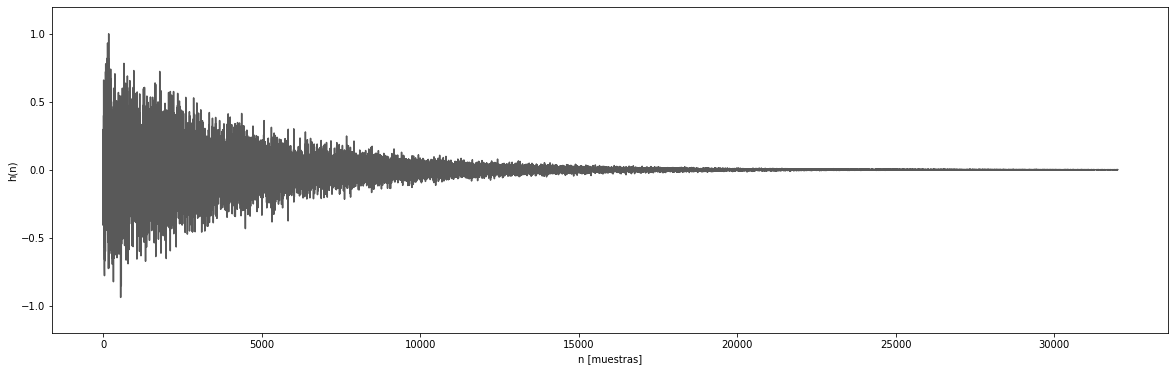

In [5]:
from filtros import butter_bandpass_filter
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
import matplotlib

def syntheticRIR(Rt, fs):
  # Reconstruir una RIR con el método de schroeder a partir de conocer el tiempo de reverberación

  t = np.arange(0, int(Rt), 1/fs)
  a = 1 #Amplitud de la RIR

  y = a*np.e**((-6.9*t)/Rt) # Creo una exponencial decreciente

  seed = randrange(int(2**32))
  
  np.random.seed(seed)
  n = np.random.normal(0, 1, y.shape) #Genero ruido blanco

  y = y*n #+ n*0.01#Multiplico el ruido por la señal

  return y/max(np.abs(y)), seed

rir, _ = syntheticRIR(2, 16000)


#plt.style.use('grayscale')
plt.figure(facecolor='white', figsize=[20,6], )
plt.plot(rir, color='0.35')
plt.ylabel('h(n)')
plt.xlabel('n [muestras]')
plt.ylim(-1.2,1.2)
matplotlib.rcParams.update({'font.size': 22})

plt.show()

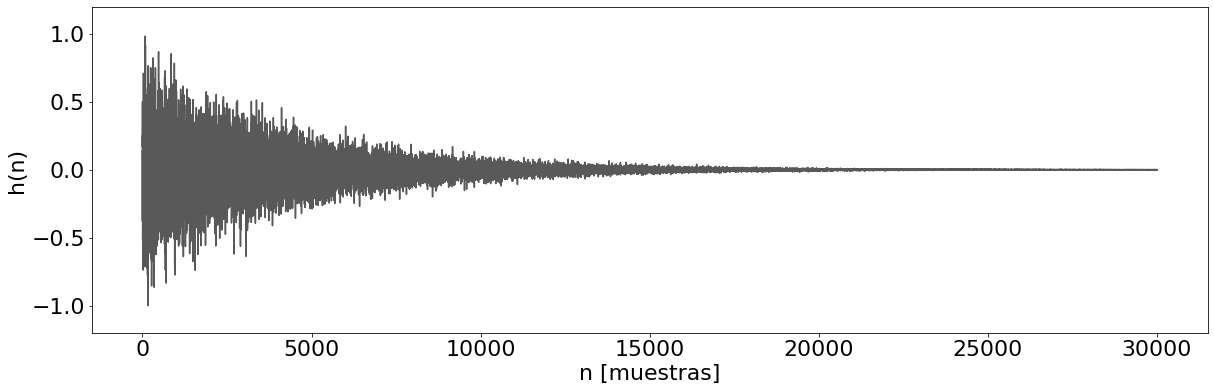

In [ ]:
# Recorto la rir:
rir = rir[:30000]

plt.figure(facecolor='white', figsize=[20,6], )
plt.plot(rir, color='0.35')
plt.ylabel('h(n)')
plt.xlabel('n [muestras]')
plt.ylim(-1.2,1.2)
matplotlib.rcParams.update({'font.size': 22})

plt.show()

In [ ]:
import numpy as np
from scipy import stats
from scipy.signal import hilbert

def tr_convencional(raw_signal, fs, rt='t30'):  # pylint: disable=too-many-locals
    """
    Reverberation time from an impulse response.
    :param file_name: name of the WAV file containing the impulse response.
    :param bands: Octave or third bands as NumPy array.
    :param rt: Reverberation time estimator. It accepts `'t30'`, `'t20'`, `'t10'` and `'edt'`.
    :returns: Reverberation time :math:`T_{60}`
    """

    rt = rt.lower()
    if rt == 't30':
        init = -5.0
        end = -35.0
        factor = 2.0
    elif rt == 't20':
        init = -5.0
        end = -25.0
        factor = 3.0
    elif rt == 't10':
        init = -5.0
        end = -15.0
        factor = 6.0
    elif rt == 'edt':
        init = 0.0
        end = -10.0
        factor = 6.0

    abs_signal = np.abs(raw_signal) / np.max(np.abs(raw_signal))

    #Hilbert plot:
    y = abs_signal**2
    y = np.abs(hilbert(abs_signal))
    decay_curve = 20*np.log10(y / np.max(y))

    # Schroeder integration
    sch = np.cumsum(abs_signal[::-1]**2)[::-1]
    sch_db = 10.0 * np.log10(sch / np.max(sch))

    # Linear regression
    sch_init = sch_db[np.abs(sch_db - init).argmin()]
    sch_end = sch_db[np.abs(sch_db - end).argmin()]
    init_sample = np.where(sch_db == sch_init)[0][0]
    end_sample = np.where(sch_db == sch_end)[0][0]
    x = np.arange(init_sample, end_sample + 1) / fs
    y = sch_db[init_sample:end_sample + 1]
    slope, intercept = stats.linregress(x, y)[0:2]

    # Reverberation time (T30, T20, T10 or EDT)
    db_regress_init = (init - intercept) / slope
    db_regress_end = (end - intercept) / slope
    t60 = factor * (db_regress_end - db_regress_init)

    return t60, decay_curve, sch_db, x*fs, slope/fs, intercept/fs

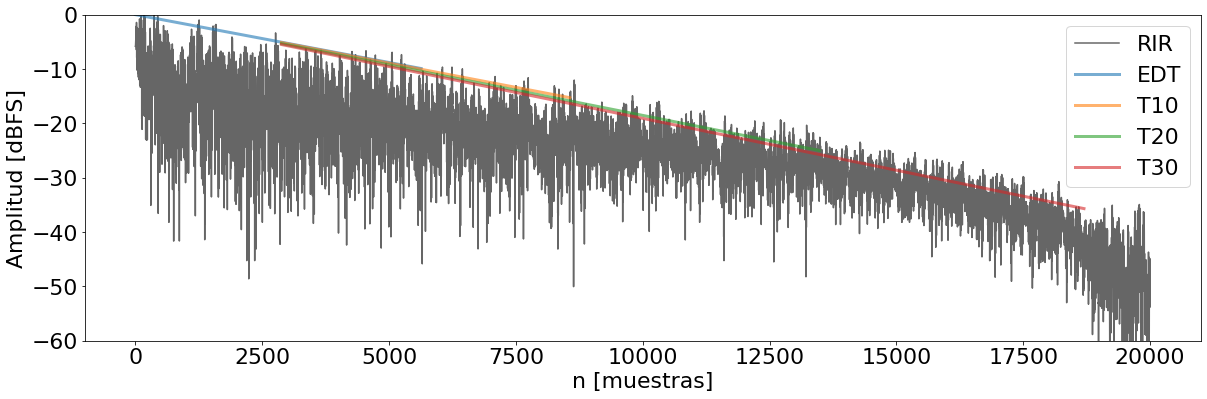

In [ ]:
#Genero el decay y sus curvas de fiteo:
import librosa

data, fs = librosa.load('/content/drive/My Drive/Tesis/Base de datos/ejemplo_rir.wav', sr=16000)

band=1000
lowcut, highcut = band/(2**(1/2)), band*(2**(1/2))
rir_1000 = butter_bandpass_filter(rir, lowcut, highcut, 16000, 4)

_, decay_curve, sch, x_fit_edt, slope_edt, intercept_edt = tr_convencional(rir_1000, fs=16000, rt='edt')
_, decay_curve, sch, x_fit_t10, slope_t10, intercept_t10 = tr_convencional(rir_1000, fs=16000, rt='t10')
_, decay_curve, sch, x_fit_t20, slope_t20, intercept_t20 = tr_convencional(rir_1000, fs=16000, rt='t20')
_, decay_curve, sch, x_fit_t30, slope_t30, intercept_t30 = tr_convencional(rir_1000, fs=16000, rt='t30')


plt.figure(facecolor='white', figsize=[20,6], )

plt.ylim(-60, 0)
plt.plot(decay_curve[:20000], label='RIR', color='0.4')

plt.plot(x_fit_edt, intercept_edt + slope_edt*x_fit_edt, label='EDT', linewidth=3, alpha=0.6)
plt.plot(x_fit_t10, intercept_t10 + slope_t10*x_fit_t10, label='T10', linewidth=3, alpha=0.6)
plt.plot(x_fit_t20, intercept_t20 + slope_t20*x_fit_t20, label='T20', linewidth=3, alpha=0.6)
plt.plot(x_fit_t30, intercept_t30 + slope_t30*x_fit_t30, label='T30', linewidth=3, alpha=0.6)

plt.ylabel('Amplitud [dBFS]')
plt.xlabel('n [muestras]')

plt.legend()
plt.show()

TAE:

In [6]:
import sys
sys.path.append('/content/drive/My Drive/Tesis/Notebooks/scripts')
from scipy.signal import fftconvolve
from filtros import butter_lowpass_filter
from librosa import resample
from scipy.signal import butter, sosfilt, lfilter, fftconvolve, hilbert
from librosa import load

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    sos = butter(order, [lowcut, highcut], fs=fs, btype='bandpass', output='sos')
    y = sosfilt(sos, data)
    return y

def TAE_for_plot(data, fs):
  # Filtro la señal por banda de octava entre 125 y 4k Hz
  fs = fs #frecuencia de sampleo

  #Transformada de Hilbert
  analytic_signal = hilbert(data)
  #Obtengo la envolvente
  amplitude_envelope = np.abs(analytic_signal)

  #Obtengo la TAE a partir del resampleo y filtrado de la señal:
  cutoff = 20 # Frecuencia de corte a 20 Hz
  order = 4

  tae = butter_lowpass_filter(amplitude_envelope, cutoff, fs, order) # Le paso un filtro pasabajos a la envolvente

  #Downsampleo la señal:
  tae = resample(tae, orig_sr=fs, target_sr=40)

  tae = tae/np.max(tae)

  return amplitude_envelope, tae

audio, fs = load('/content/drive/My Drive/Tesis/Base de datos/ACE Challenge selected/F1s3.wav', sr=16000)

audio = audio[:int(5*fs)]

audio_reverb = fftconvolve(audio, rir, mode='same') #Plotear esta

band=1000
lowcut, highcut = band/(2**(1/2)), band*(2**(1/2))

audio_filtrado = butter_bandpass_filter(audio_reverb, lowcut, highcut, fs, 4) #Plotear esta

amplitude_envelope, tae = TAE_for_plot(audio_filtrado, fs) #Plotear estas

[]

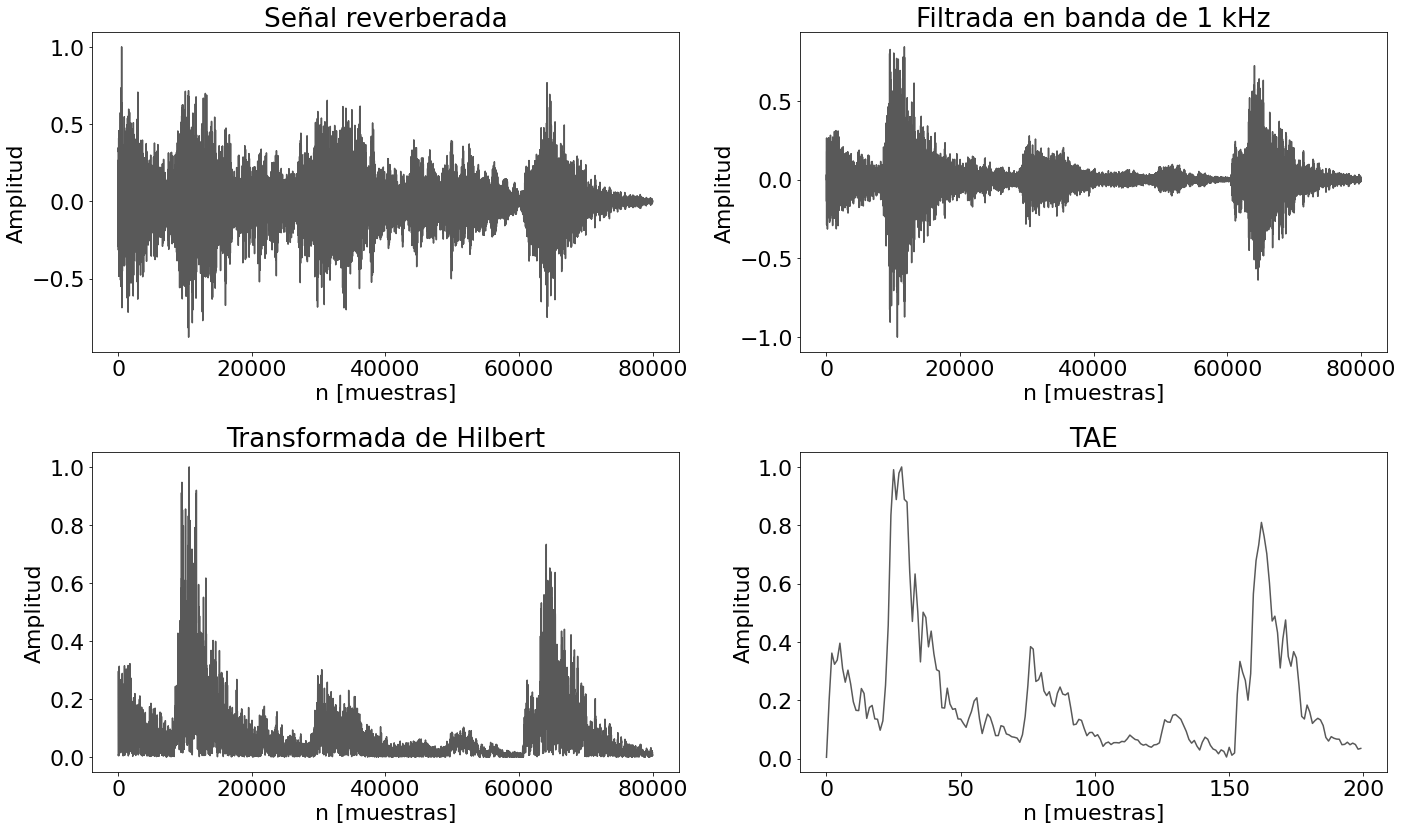

In [7]:
import matplotlib.pyplot as plt

# using the variable axs for multiple Axes
fig, axs = plt.subplots(2, 2, figsize=(20,12))

axs[0, 0].plot(audio_reverb/np.max(np.abs(audio_reverb)), color='0.35')
axs[0, 1].plot(audio_filtrado/np.max(np.abs(audio_filtrado)), color='0.35')
axs[1, 0].plot(amplitude_envelope/np.max(np.abs(amplitude_envelope)), color='0.35')
axs[1, 1].plot(tae, color='0.35')

axs[0, 0].set_title('Señal reverberada')
axs[0, 1].set_title('Filtrada en banda de 1 kHz')
axs[1, 0].set_title('Transformada de Hilbert')
axs[1, 1].set_title('TAE')

axs = axs.T.flatten()

for subplot in axs:
    subplot.set_xlabel("n [muestras]")
    subplot.set_ylabel("Amplitud")

plt.tight_layout()
plt.plot()


Envolvente de una señal:

[]

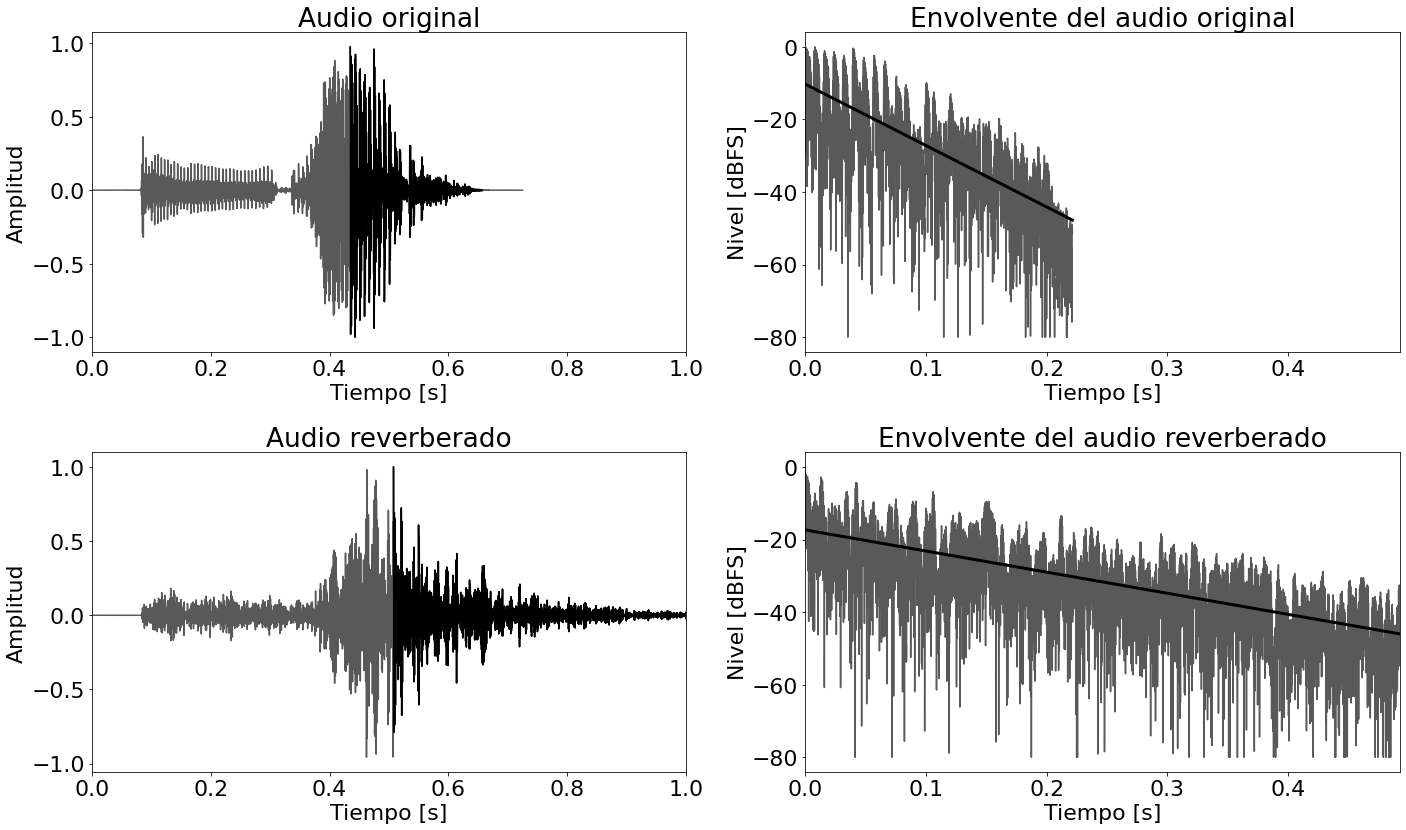

In [ ]:
audio, fs = load('/content/drive/My Drive/Tesis/Base de datos/pera.wav', sr=16000)

band=1000
lowcut, highcut = band/(2**(1/2)), band*(2**(1/2))

audio = butter_bandpass_filter(audio, lowcut, highcut, fs, 4) #Plotear esta

#audio = audio[:int(5*fs)]
#audio = fftconvolve(audio, rir, mode='same') 
#audio = audio[64000:77000] #Plotear esta

#rir, fs = load('/content/drive/My Drive/Tesis/Base de datos/ejemplo_rir.wav', sr=16000)
rir, _ = syntheticRIR(1, 16000)

audio_reverb = fftconvolve(audio, rir,mode='full') #Plotear esta

#audio = audio[:6000]
audio_reverb = audio_reverb[:16000]

fig, axs = plt.subplots(2, 2, figsize=(20,12))

audio = audio/np.max(np.abs(audio))
audio_reverb = audio_reverb/np.max(np.abs(audio_reverb))

time1 = np.linspace(0, len(audio)/fs, num=int(len(audio)))
time2 = np.linspace(0, len(audio_reverb)/fs, num=int(len(audio_reverb)))

axs[0, 0].plot(time1, audio, color='0.35')
axs[0, 0].plot(time1[np.where(audio==np.max(audio))[0][0]:10500], audio[np.where(audio==np.max(audio))[0][0]:10500], color = 'black')
axs[1, 0].plot(time2, audio_reverb, color='0.35')
axs[1, 0].plot(time2[np.where(audio_reverb==np.max(audio_reverb))[0][0]:], audio_reverb[np.where(audio_reverb==np.max(audio_reverb))[0][0]:], color = 'black')

audio_dB = librosa.amplitude_to_db(audio[np.where(audio==np.max(audio))[0][0]:10500])
audio_reverb_dB = librosa.amplitude_to_db(audio_reverb[np.where(audio_reverb==np.max(audio_reverb))[0][0]:])

time_dB = np.linspace(0, len(audio_dB)/fs, num=int(len(audio_dB)))
time_reverb_dB = np.linspace(0, len(audio_reverb_dB)/fs, num=int(len(audio_reverb_dB)))

m, b = np.polyfit(time_dB, audio_dB, 1)
m2, b2 = np.polyfit(time_reverb_dB, audio_reverb_dB, 1)


axs[0,1].plot(time_dB, audio_dB, color='0.35')
axs[0,1].plot(time_dB, m*time_dB + b, color='black', linewidth=3)
axs[1,1].plot(time_reverb_dB, audio_reverb_dB, color='0.35')
axs[1,1].plot(time_reverb_dB, m2*time_reverb_dB + b2, color = 'black', linewidth=3)

axs[0, 0].set_xlim(0, time2[-1])
axs[1, 0].set_xlim(0, time2[-1])
axs[0, 1].set_xlim(0, time_reverb_dB[-1])
axs[1, 1].set_xlim(0, time_reverb_dB[-1])

axs[0, 0].set_title('Audio original')
axs[0, 1].set_title('Envolvente del audio original')
axs[1, 0].set_title('Audio reverberado')
axs[1, 1].set_title('Envolvente del audio reverberado')

axs = axs.T.flatten()

i=0
for subplot in axs:

  if i == 0:
    subplot.set_xlabel("Tiempo [s]")
    subplot.set_ylabel("Amplitud")
  elif i == 1:
    subplot.set_xlabel("Tiempo [s]")
    subplot.set_ylabel("Amplitud")
  elif i == 2:
    subplot.set_xlabel("Tiempo [s]")
    subplot.set_ylabel("Nivel [dBFS]")
  elif i == 3:
    subplot.set_xlabel("Tiempo [s]")
    subplot.set_ylabel("Nivel [dBFS]")
  i+=1

plt.tight_layout()
plt.plot()

# Funciones de activación:

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(x):
    ''' Compute softmax values for each sets of scores in x. '''
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def Step(x):
    x1=[]
    for i in x:
        if i<0:
            x1.append(-1)
        elif i==0:
            x1.append(0)
        else:
            x1.append(1)

    return x1

def linear(x):
    ''' y = f(x) It returns the input as it is'''
    return x

def RELU(x):
    ''' It returns zero if the input is less than zero otherwise it returns the given input. '''
    x1=[]
    for i in x:
        if i<0:
            x1.append(0)
        else:
            x1.append(i)

    return x1

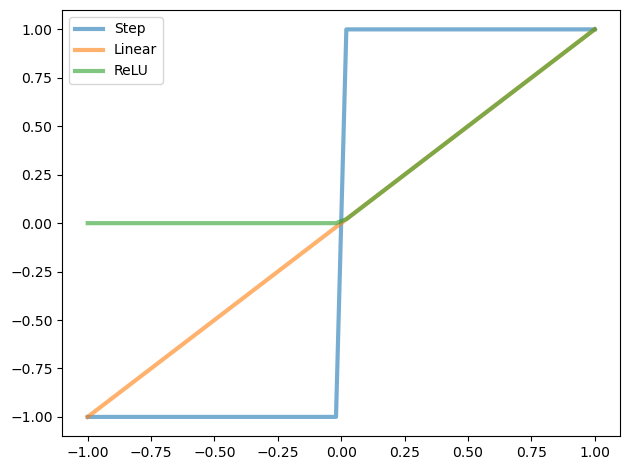

In [32]:
x = np.linspace(-1, 1)

#soft = softmax(x)
escalon = Step(x)
lineal = linear(x)
relu = RELU(x)

#plt.plot(x, soft, label='Softmax')
#plt.figure(facecolor='white', figsize=[10,7], )

plt.plot(x, escalon, label='Step', linewidth=3, alpha=0.6)
plt.plot(x, lineal, label='Linear', linewidth=3, alpha=0.6)
plt.plot(x, relu, label='ReLU', linewidth=3, alpha=0.6)

plt.tight_layout()
plt.legend()

plt.show()


# Banco de filtros:

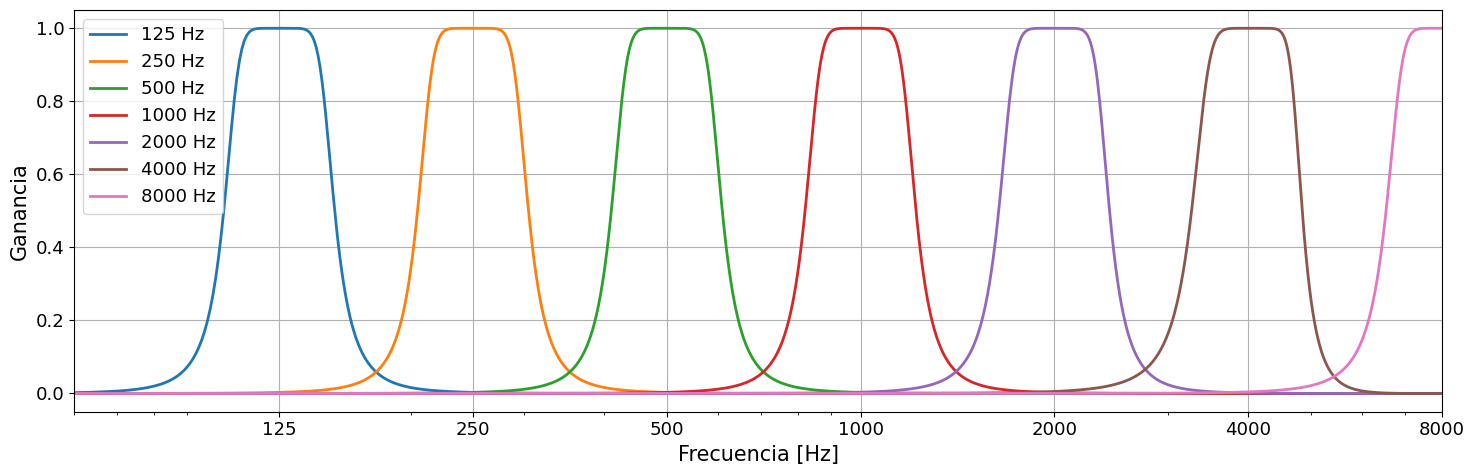

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib

#Manganeta para no hacer log(0):
eps = np.finfo(float).eps

def sbutter_bandpass(lowcut, highcut, fs, order):
    """ Diseña un filtro pasabanda a partir de especificar las frecuencias 
    de corte superior e inferior, la frecuencia de sampleo y el orden del filtro """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = signal.butter(order, [low, high], btype='band', output='sos')
    return sos

def sbutter_bandpass_filter(data, lowcut, highcut, fs, order):
    """ filtra una señal (data) a partir de diseñar un filtro pasabanda
    tipo butter a partir de las frecuencias de corte superior e inferior
    la frecuencia de sampleo y el orden del filtro. Devuelve la señal filtrada
    en tiempo """
    sos = sbutter_bandpass(lowcut, highcut, fs, order)
    y = signal.sosfilt(sos, data)
    return y

def sbutter_highpass(cutoff, fs, order):

    nyq = 0.5 * fs
    #cutoff = cutoff/nyq
    sos = signal.butter(order, cutoff, fs=fs, btype='hp', output='sos')

    return sos

def Leq(y,fs):
    'Calcula el nivel equivalente sin ponderacion de la señal y'
    N = len(y) #Numero de intervalos
    aux = np.sum(np.power(10,y/10))
    leq = 10*np.log10((1/N)*aux)
    return leq

def fft(signal, fs):
    fft_raw = np.fft.fft(signal)
    fft = fft_raw[:len(fft_raw)//2]
    fft_mag = abs(fft) / len(fft)
    freqs = np.linspace(0, fs/2, fft.size)
    return fft_mag, freqs

def plot_fft(mag, freqs, title, ax):
    mag_db = 20*np.log10(mag)
    ax.semilogx(freqs, mag_db)
    ax.set_xlim(20,freqs[-1])
    xfreqs = [62.5*(2**i) for i in range(8)]
    ax.set_xticks(xfreqs)
    ax.set_xticklabels([f'{f:.0f}' for f in xfreqs])
    ax.set_title(title)
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Amplitude [dB]')
    ax.set_ylim(-80,2)


fs = 16000
order = 4

#octavas
center_freq = [125, 250, 500, 1000, 2000, 4000, 8000]
ticks_labels=['125', '250', '500', '1000', '2000', '4000', '8000']
n = 2 #octava

plt.figure(figsize=[15,5])

for f in center_freq:
  try:
    sos = sbutter_bandpass(f*np.power(2,(-1)/(2*n)), f*np.power(2,1/(2*n)), fs, order)
  except Exception:
    sos = sbutter_highpass(f*np.power(2,(-1)/(2*n)), fs, order)

  w, h = signal.sosfreqz(sos, worN=8192)
  plt.semilogx((w*fs)/(np.pi*2), abs(h), linewidth=2, label=f'{f} Hz')#20*np.log10(abs(h)+eps))
#plt.ylim(-50,5)
plt.xlim(60,8000)

plt.xlabel('Frecuencia [Hz]', fontsize=15)
plt.ylabel('Ganancia', fontsize=15)

plt.xticks(center_freq, ticks_labels, fontsize=13)
plt.yticks(fontsize=13)

matplotlib.rcParams.update({'font.size': 15})

plt.grid()

plt.legend(prop={'size': 13})

plt.tight_layout()

plt.show()

# Aumentación DRR:

In [1]:
import numpy as np
import librosa 
import matplotlib.pyplot as plt

In [2]:
rir, fs = librosa.load('../data/RIRs/x02y00.wav', sr=None)
rir = rir / np.max(abs(rir))
def bhaskara(a, b, c):
    r = b**2 - 4*a*c
    if r > 0:
        num_roots = 2
        x1 = (((-b) + np.sqrt(r))/(2*a))
        x2 = (((-b) - np.sqrt(r))/(2*a))
        return np.max((x1, x2))
    elif r == 0:
        num_roots = 1
        x = (-b) / 2*a
        return x
    else:
        num_roots = 0
        return

In [3]:
t_d = np.argmax(rir) # direct path                                                     
t_o = int((0.0025) * fs) #tolerance window in samples                      
init_idx = t_d - t_o
final_idx = t_d + t_o + 1

if init_idx < 0:
    init_idx = 0
if final_idx > len(rir)-1:
    final_idx = len(rir)-1

early= rir[init_idx:final_idx]
late = rir[final_idx:]

In [6]:
DRR_buscado = -5
#Busco el coeficiente para llegar a la DRR deseada
w = np.hamming((t_o*2)+1) #ventana de hamming de 5ms
a = np.sum((w**2) * (early**2))
b = 2 * np.sum((1-w)*w*(early**2))
c = np.sum(((1-w)**2)*(early**2))-(np.power(10,DRR_buscado/10)*np.sum(late**2))
alpha = bhaskara(a, b, c)

#Defino la nueva parte early
new_early = (alpha * w * early) + ((1 - w)*early)
if np.max(abs(new_early))<np.max(abs(late)):
    print("El nivel deseado es demasiado bajo")
    new_early = early

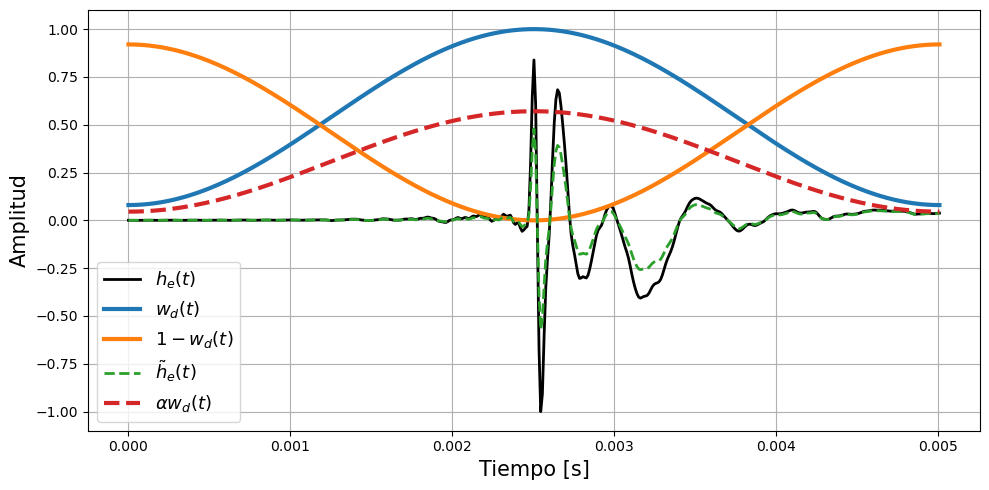

In [14]:
t = np.linspace(0, len(early)/fs, len(early))
plt.figure(1, figsize=(10,5))
plt.plot(t,early, linewidth=2.0 ,label=r'$h_{e}(t)$', color='black')
plt.plot(t,w, '-', linewidth=3.0, label=r'$w_{d}(t)$')
plt.plot(t,1-w, '-', linewidth=3.0, label=r'$1-w_{d}(t)$')
plt.plot(t,new_early, '--', linewidth=2.0, label = r'$\tilde{h}_{e}(t)$')
plt.plot(t,alpha*w, '--', linewidth=3.0, label = r'$\alpha w_{d}(t)$')
plt.grid()
plt.xlabel('Tiempo [s]', size=15)
plt.ylabel('Amplitud', size=15)
plt.legend(prop={'size': 13})

plt.tight_layout()

plt.savefig('drr_aug.png')

# Ejemplo de RIRs sintéticas:

In [18]:
import librosa
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

rir_low, fs = librosa.load('../data/RIRs/sintetica_Seed87057939_Tr1.0.wav', sr=None)
rir_mid, fs = librosa.load('../data/RIRs/sintetica_Seed122373349_Tr2.0.wav', sr=None)
rir_high, fs = librosa.load('../data/RIRs/sintetica_Seed126710053_Tr3.0.wav', sr=None)

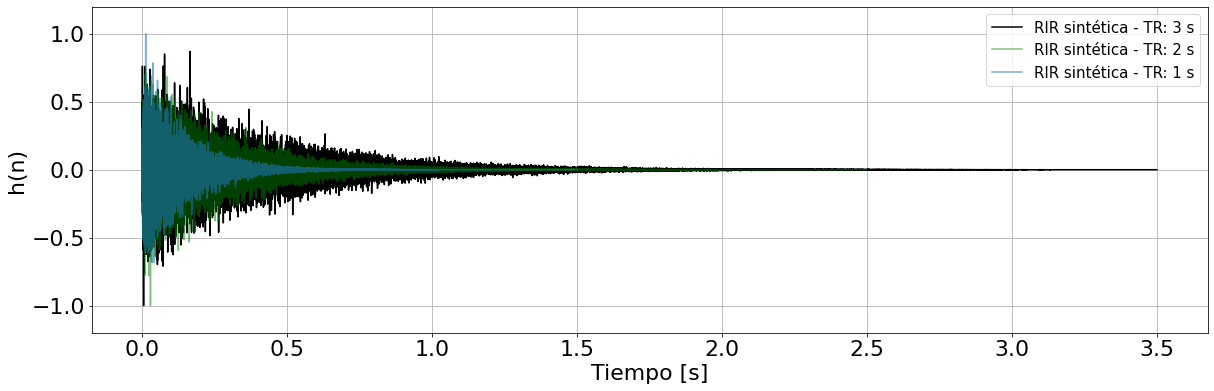

In [26]:
t_1 = np.linspace(0, len(rir_high)/fs, len(rir_high))
t_2 = np.linspace(0, len(rir_mid)/fs, len(rir_mid))
t_3 = np.linspace(0, len(rir_low)/fs, len(rir_low))

plt.figure(facecolor='white', figsize=[20,6], )
plt.plot(t_1, rir_high, color='black', label = 'RIR sintética - TR: 3 s')
plt.plot(t_2, rir_mid, color='green', label = 'RIR sintética - TR: 2 s', alpha = 0.5)
plt.plot(t_3, rir_low, label = 'RIR sintética - TR: 1 s', alpha = 0.6)
plt.ylabel('h(n)')
plt.xlabel('Tiempo [s]')
plt.ylim(-1.2,1.2)
matplotlib.rcParams.update({'font.size': 22})

plt.grid()
plt.legend(prop={'size': 15})
plt.show()